# Monografia version en jupyter

In [52]:
#Monografia - Modelo predictivo para la clasificacion si una persona renueva o no (Continua o no)

# debo reemplazar dataset porque no esta la imputacion de los null de genero y el cambio de municipio en el codigo. para la practica se dejara asi

#Se extrajo un dataset o un archivo de csv desde la DIAN para identificar el tipo de zona geografia (Urbano y rural)
#  para agrupar la ubicacion de los titulares
# Mediante analitica de texto con diccionario de nombres se realizo la imputacion de los null en la variable de genero

  
#======================Librerias para manipular=====================
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

#===========================Completar NULL de genero=============================
from genderize import Genderize


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
#from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [53]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot

In [54]:
#===============DATASET============================
# los datos para el modelo: recueda no hemos sacado la muestra.
ruta_archivo ="Base_Monografia.csv"
df  = pd.read_csv(ruta_archivo, delimiter=';')
print(df.info())  # Verificar lo que se monto
print(f"Total registros: {len(df)}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57461 entries, 0 to 57460
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               57461 non-null  object 
 1   Poliza_Grupal                       57461 non-null  int64  
 2   Id_Titular                          57461 non-null  object 
 3   Contrato                            57461 non-null  int64  
 4   Estado                              57378 non-null  object 
 5   Genero                              23019 non-null  object 
 6   Primer_nombre                       57451 non-null  object 
 7   Edad_Titular                        57015 non-null  float64
 8   Ingreso_Titular                     57461 non-null  object 
 9   Municipio                           57461 non-null  object 
 10  Forma_pago                          57461 non-null  int64  
 11  Vigencia_del_contrato               57461

In [55]:
#Cuantos nulos se tienen
print(df.groupby('Genero').Genero.count().sort_values(ascending=False))

Genero
M    11913
F    11106
Name: Genero, dtype: int64


In [56]:
#Se anexa el siguiente archivo para unificar los munificos por tipo de geografia, el archivo se trae gracias a informacion de la dian
#Clasificando cuando un municipio es considerado rural o urbano

#Municipios ="C:\\Users\\lrebolledo\\Documents\\Monografia\\municipios.csv"

ruta_municipio = "municipios.csv"
municipio = pd.read_csv(ruta_municipio, delimiter=';')

print(municipio.info())  # Verificar lo que se montó
print(f"Total registros: {len(municipio)}")


# Asegúrate de que ambas columnas a fusionar tengan el mismo nombre
# Si la columna que contiene el nombre del municipio se llama "municipio" en ambos DataFrames,
# puedes hacer la fusión directamente.

# Supongamos que tu DataFrame principal se llama df_principal y tiene la columna "municipio"
# que contiene los nombres de los municipios.

# Leer tu DataFrame principal (asegurate de sustituir con el nombre correcto)
#df_principal = pd.read_csv('ruta_a_tu_dataframe.csv')

# Realizamos un merge entre ambos DataFrames en base a la columna 'municipio'
df = pd.merge(df, municipio[['Municipio', 'tipo_geografia']], on='Municipio', how='left')

# Mostrar el DataFrame resultante
#print(df)
print(df.info())  # Verificar lo que se montó


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Municipio       753 non-null    object
 1   tipo_geografia  753 non-null    object
dtypes: object(2)
memory usage: 11.9+ KB
None
Total registros: 753
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58005 entries, 0 to 58004
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               58005 non-null  object 
 1   Poliza_Grupal                       58005 non-null  int64  
 2   Id_Titular                          58005 non-null  object 
 3   Contrato                            58005 non-null  int64  
 4   Estado                              57922 non-null  object 
 5   Genero                              23242 non-null  object 
 6   Primer_nombre      

In [57]:
#liminar los datos nulos de la edad. Ya que esos datos no se pueden imputar dado a la naturaleza del negocio
#Por lo tanto se aplica un eliminar la fila que contenga nulo, ya que la informacion ya no nos serviria
df = df.dropna ()
print(f"Total registros: {len(df)}")
print(df.info())  # Verificar lo que se monto

Total registros: 23184
<class 'pandas.core.frame.DataFrame'>
Index: 23184 entries, 0 to 58004
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               23184 non-null  object 
 1   Poliza_Grupal                       23184 non-null  int64  
 2   Id_Titular                          23184 non-null  object 
 3   Contrato                            23184 non-null  int64  
 4   Estado                              23184 non-null  object 
 5   Genero                              23184 non-null  object 
 6   Primer_nombre                       23184 non-null  object 
 7   Edad_Titular                        23184 non-null  float64
 8   Ingreso_Titular                     23184 non-null  object 
 9   Municipio                           23184 non-null  object 
 10  Forma_pago                          23184 non-null  int64  
 11  Vigencia_del_contrato  

In [59]:
#=====Exploracion de DATASET y sus variables===================================
print(df.info())
#Lista de variables categóricas
catCols = df.select_dtypes(include = ["object", 'category']).columns.tolist()
#catCols= df['Casado']
#Se elimina la columna estado de la lista de variables Categóricas ya que es nuestra variable de salida
columns_to_remove = ['Estado', 'Municipio', 'Id_Titular', 'Ingreso_Titular', 'Fecha_Renovacion_Actual', 'Primer_nombre']
catCols = [col for col in catCols if col not in columns_to_remove]

print(df[catCols].info())



<class 'pandas.core.frame.DataFrame'>
Index: 23184 entries, 0 to 58004
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Canal                               23184 non-null  object 
 1   Poliza_Grupal                       23184 non-null  int64  
 2   Id_Titular                          23184 non-null  object 
 3   Contrato                            23184 non-null  int64  
 4   Estado                              23184 non-null  object 
 5   Genero                              23184 non-null  object 
 6   Primer_nombre                       23184 non-null  object 
 7   Edad_Titular                        23184 non-null  float64
 8   Ingreso_Titular                     23184 non-null  object 
 9   Municipio                           23184 non-null  object 
 10  Forma_pago                          23184 non-null  int64  
 11  Vigencia_del_contrato               23184 non-

In [60]:
#Lista de variables numéricas
numCols=df.select_dtypes(include = ['int64']).columns.tolist()


columns_num_to_remove = ['Casado', 'Poliza_Grupal', 'Contrato']
numCols = [col for col in numCols if col not in columns_num_to_remove]
print(df[numCols].info())

<class 'pandas.core.frame.DataFrame'>
Index: 23184 entries, 0 to 58004
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Forma_pago                          23184 non-null  int64
 1   Vigencia_del_contrato               23184 non-null  int64
 2   Numero_de_pagos                     23184 non-null  int64
 3   Valor_Pagado                        23184 non-null  int64
 4   periocidad_cambiante                23184 non-null  int64
 5   Numero_recompras_o_renovacion       23184 non-null  int64
 6   Contratos_activos_anteriores        23184 non-null  int64
 7   Valor_Contratos_activos_anteriores  23184 non-null  int64
 8   Beneficiario                        23184 non-null  int64
 9   Mascotas                            23184 non-null  int64
 10  Exequial_Personas                   23184 non-null  int64
 11  Auxilio                             23184 non-null  int64
 12  Asistenci

In [61]:
#==========================para evaluar========================
# Distribución de cada variable categórica en el conjunto de datos

#for col in catCols:
 #  print("="*5 + f" {col} " + "="*20)
  # print(df[col].value_counts())
   #print()
#De aqui se evidencia como reorganizar como los metodos de pago. Unificarlos en 3 (PAGO EN CAJA, FACTURA{FACTURA, CONVENIO,CUENTA DE COBRO}, PSE{DEBITO,DESCUENTO DE NOMINA,TARJETA DE CREDITO})


#VARIABLE DE SALIDA
print(df.groupby('Estado').Estado.count().sort_values(ascending=False))


Estado
Renovo       14622
No Renovo     8562
Name: Estado, dtype: int64


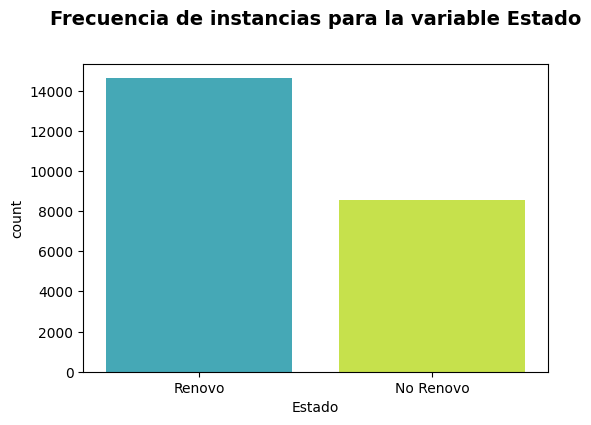

In [ ]:
multiple_plot(1, df , None, 'Estado', 'countplot', 'Frecuencia de instancias para la variable Estado',0)


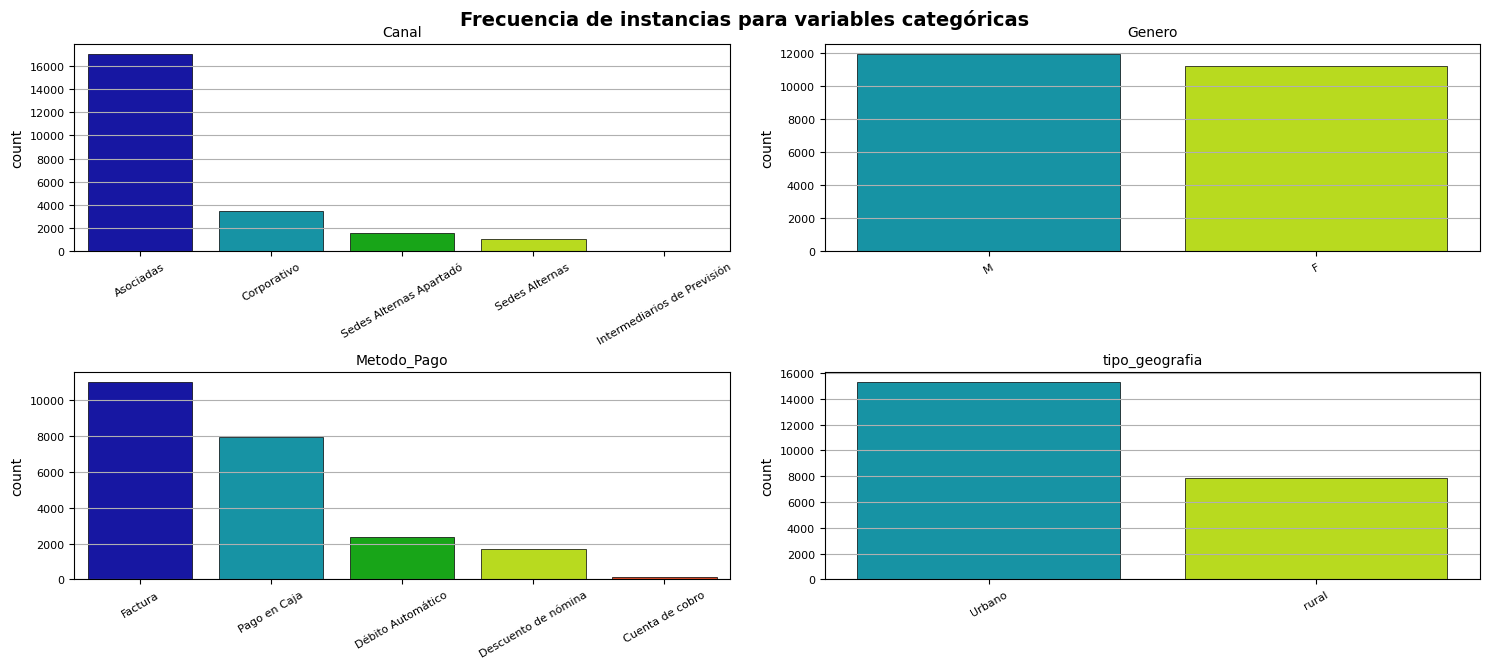

In [43]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(2, df , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [44]:
#Cambios en la data 

# Cambiar 'sex' de 'M' y 'F' a 1 y 0


#onehot-code Dummificación, Cambiar a metodologia
df['Genero'] = df['Genero'].replace({'M': 1, 'F': 0}).astype(int)
df['tipo_geografia'] = df['tipo_geografia'].replace({'Urbano': 1, 'rural': 0}).astype(int)



df['Metodo_Pago'] = df['Metodo_Pago'].replace({'Factura': 1, 'Cuenta de cobro': 1,'Convenio': 1,'Pago en Caja': 0,'Débito Automático': 2,'Descuento de nómina': 2,'Tarjeta crédito': 2}).astype(int)
#buscar literatura e informacion para definir y argumentar el porque


for col in catCols:
   print("="*5 + f" {col} " + "="*20)
   print(df[col].value_counts())
   print()

 

===== Canal ====================
Canal
Asociadas                      17043
Corporativo                     3499
Sedes Alternas Apartadó         1555
Sedes Alternas                  1050
Intermediarios de Previsión       37
Name: count, dtype: int64

===== Genero ====================
Genero
1    11956
0    11228
Name: count, dtype: int64

===== Metodo_Pago ====================
Metodo_Pago
1    11159
0     7959
2     4066
Name: count, dtype: int64

===== tipo_geografia ====================
tipo_geografia
1    15294
0     7890
Name: count, dtype: int64



In [45]:
# Distribución de cada variable Numericas en el conjunto de datos, Para identificar como unificarla

for col in numCols:
    print("="*5 + f" {col} " + "="*20)
    print(df[col].value_counts())
    print()



#Crear rango o subcategoricas para clasificarlos 
#menor de 30 = 30 dia
#1 a 6 meses
#año a mas 

===== Forma_pago ====================
Forma_pago
30      12572
360      7185
14       1243
180      1123
720       448
1080      332
120       133
60         63
90         48
15         26
150        11
Name: count, dtype: int64

===== Vigencia_del_contrato ====================
Vigencia_del_contrato
360     21075
180       755
720       448
330       416
1080      334
120       133
150        12
30          5
240         4
300         2
Name: count, dtype: int64

===== Numero_de_pagos ====================
Numero_de_pagos
12    3691
10    3600
9     1493
6     1455
5     1289
15    1226
4     1083
3     1031
1      997
11     945
2      929
8      866
7      839
0      708
24     498
14     495
13     482
16     328
36     318
17     276
18     250
22     155
21      98
19      75
20      28
23      17
28       3
25       2
26       2
63       1
31       1
34       1
80       1
35       1
Name: count, dtype: int64

===== Valor_Pagado ====================
Valor_Pagado
18500     574
37200

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
# Asegúrate de que solo las columnas numéricas sean seleccionadas
numCols = df.select_dtypes(include=['float64', 'int64']).columns

# Crea una instancia de StandardScaler
scaler = StandardScaler()

# Aplica el escalado solo a las columnas numéricas
X_scaled = scaler.fit_transform(df[numCols])

# Si deseas agregar las columnas escaladas al DataFrame, puedes hacer lo siguiente:
df[numCols] = X_scaled



In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor



param_grid = {'n_neighbors': [5, 10, 15, 20, 25]}
lof = LocalOutlierFactor()

grid_search = GridSearchCV(lof, param_grid, cv=5, scoring='f1_micro')
grid_search.fit(X_scaled)  # Donde X es tu conjunto de datos
print("Mejor número de vecinos:", grid_search.best_params_)


Mejor número de vecinos: {'n_neighbors': 5}


In [48]:
#utilización de LocalOutlierFactor con 5 vecinos para identificar valores atípicos en las variables de entrada


# crear un objeto LocalOutlierFactor con n_neighbors=13
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)

# identificar los valores atípicos por medio de lof 
y_pred = lof.fit_predict(df[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', df[outliers].index.tolist())

Indices de valores atípicos:  [0, 1, 12, 14, 15, 27, 31, 33, 42, 50, 57, 64, 74, 107, 130, 135, 136, 142, 148, 151, 165, 206, 208, 211, 236, 238, 250, 292, 341, 371, 383, 385, 396, 403, 412, 518, 528, 532, 536, 538, 539, 544, 557, 567, 570, 574, 583, 593, 610, 617, 628, 630, 631, 633, 637, 645, 653, 659, 661, 713, 720, 723, 733, 773, 783, 786, 788, 791, 793, 794, 795, 796, 799, 807, 812, 821, 824, 855, 858, 864, 866, 871, 876, 896, 897, 899, 907, 914, 936, 957, 963, 964, 979, 981, 985, 991, 994, 1001, 1024, 1030, 1035, 1039, 1040, 1085, 1089, 1105, 1133, 1259, 1269, 1273, 1316, 1319, 1322, 1326, 1329, 1330, 1331, 1335, 1347, 1350, 1354, 1362, 1363, 1374, 1376, 1377, 1378, 1379, 1380, 1384, 1387, 1389, 1390, 1391, 1393, 1394, 1408, 1416, 1418, 1421, 1426, 1433, 1436, 1448, 1453, 1465, 1517, 1596, 1665, 1728, 1732, 1740, 1742, 1766, 1767, 1782, 1815, 1831, 1834, 1837, 1838, 1841, 1867, 1889, 1891, 1924, 1926, 1966, 1973, 1978, 2012, 2020, 2024, 2026, 2046, 2050, 2054, 2060, 2061, 2108, 2

In [28]:
# Eliminar los valores atípicos del dataframe original
df = df.loc[~outliers]

In [29]:
print(f"Total registros: {len(df)}")

Total registros: 20865


In [50]:
print(df[numCols].info())

<class 'pandas.core.frame.DataFrame'>
Index: 23184 entries, 0 to 58004
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Poliza_Grupal                       23184 non-null  float64
 1   Contrato                            23184 non-null  float64
 2   Genero                              23184 non-null  float64
 3   Edad_Titular                        23184 non-null  float64
 4   Forma_pago                          23184 non-null  float64
 5   Vigencia_del_contrato               23184 non-null  float64
 6   Numero_de_pagos                     23184 non-null  float64
 7   Valor_Pagado                        23184 non-null  float64
 8   periocidad_cambiante                23184 non-null  float64
 9   Numero_recompras_o_renovacion       23184 non-null  float64
 10  Metodo_Pago                         23184 non-null  float64
 11  Contratos_activos_anteriores        23184 non-

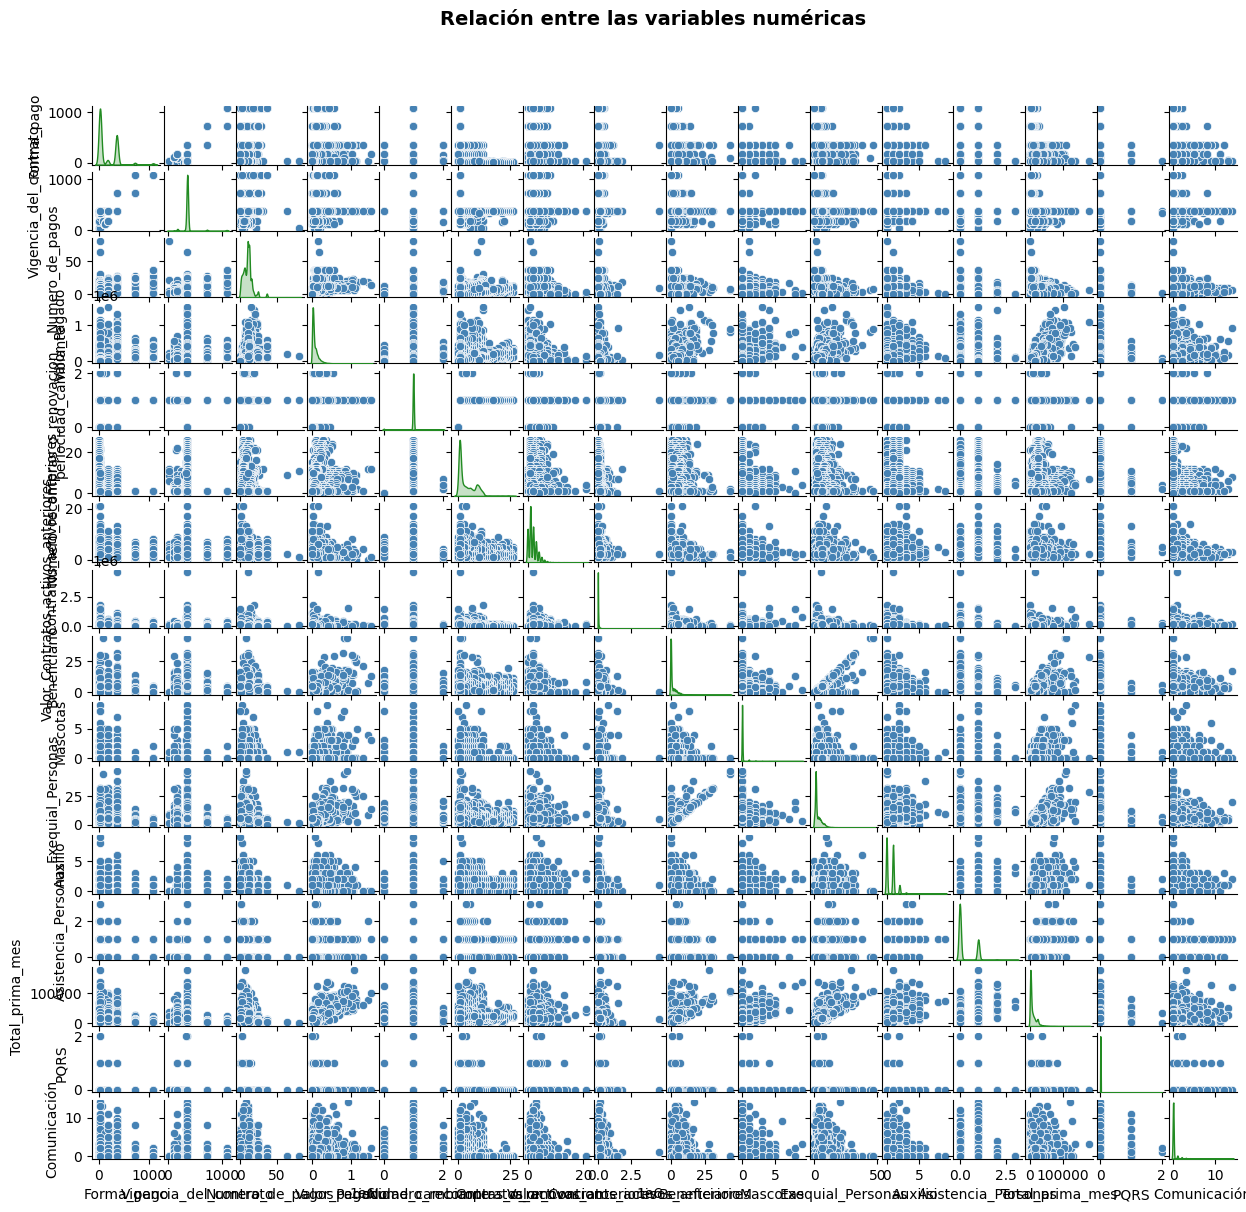

In [62]:
#Primero eliminar outliers y null


#Visualización de variables numéricas

multiple_plot(1, df , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

# Dataset final

In [63]:
# Identificación de valores nulos para las variables numéricas
for col in df[numCols]:
    print (col, np.sum(pd.isnull(df[col])))

Forma_pago 0
Vigencia_del_contrato 0
Numero_de_pagos 0
Valor_Pagado 0
periocidad_cambiante 0
Numero_recompras_o_renovacion 0
Contratos_activos_anteriores 0
Valor_Contratos_activos_anteriores 0
Beneficiario 0
Mascotas 0
Exequial_Personas 0
Auxilio 0
Asistencia_Personas 0
Total_prima_mes 0
PQRS 0
Comunicación 0


In [64]:
# Identificación de valores nulos para las variables categóricas
for col in df[catCols]:
    print (col, np.sum(pd.isnull(df[col])))

Canal 0
Genero 0
Metodo_Pago 0
tipo_geografia 0
